In [3]:
## JGRJD

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sn
import matplotlib.pyplot as plt
import xarray as xr
import datetime


In [4]:
def lowpass_scipy(signal,sample_freq,time_period,keep_mean):
    import numpy as np
    import scipy as sc
    from scipy import fftpack
    
    lowpass_signal=np.zeros(signal.shape)
    if any(np.isnan(signal)):
        raise ValueError('There is NaN in the signal')
    else:
        hf = 1./time_period

        temp_fft = sc.fftpack.fft(signal)

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
        i1 = np.abs(fftfreq) >= hf  
        
        temp_fft[i1] = 0
        if not(keep_mean):
            temp_fft[0]=0
        lowpass_signal= np.real_if_close(sc.fftpack.ifft(temp_fft))
    
    return lowpass_signal

## Reading all rmm1 files and merging them

## RMM1

In [5]:
fnames = glob.glob('*p1.txt')
count =0
df_rmm1 = pd.DataFrame([])
for file in fnames:
    df1 = pd.read_csv(file)
    df1.columns = ['Datetime','rmm1']
    df1.index = pd.to_datetime(df1.Datetime)
    df1 = df1.drop('Datetime',axis=1)
#     df1 = df1[['rmm1']]/df1['rmm1'].std()
    df_rmm1 = pd.concat([df_rmm1,df1], axis=1, join='outer', ignore_index=False)

In [6]:
len(fnames)

16

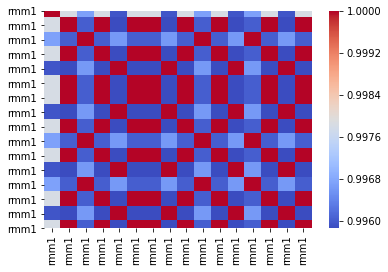

In [7]:
corrMatrix = df_rmm1.corr()
sn.heatmap(corrMatrix,cmap='coolwarm')

## Making the ensamble mean

In [8]:
rmm1_ensamble = df_rmm1.mean(axis=1)
rmm1_ensamble = rmm1_ensamble/rmm1_ensamble.loc['1979-01-01':'2008-12-31'].std()#rmm1_ensamble.std() 
# rmm1_ensamble.to_csv('ensamble_conv1d_jgrjd_rmm1_p1.csv')

/home/cccr/supriyo/.conda/envs/knp_ai/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


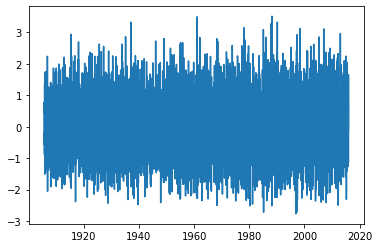

In [9]:
plt.plot(rmm1_ensamble)

## RMM2

In [10]:
fnames = glob.glob('rmm2*.txt')
count =0
df_rmm2 = pd.DataFrame([])
for file in fnames:
    df1 = pd.read_csv(file)
    df1.columns = ['Datetime','rmm2']
    df1.index = pd.to_datetime(df1.Datetime)
    df1 = df1.drop('Datetime',axis=1)
#     df1 = df1[['rmm1']]/df1['rmm1'].std()
    df_rmm2 = pd.concat([df_rmm2,df1], axis=1, join='outer', ignore_index=False)

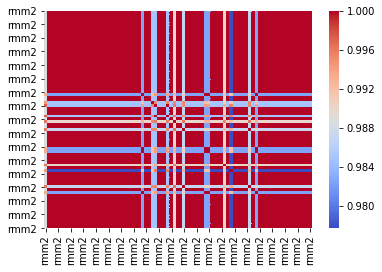

In [11]:
corrMatrix = df_rmm2.corr()
sn.heatmap(corrMatrix,cmap='coolwarm')

In [12]:
rmm2_ensamble = df_rmm2.mean(axis=1)
rmm2_ensamble = rmm2_ensamble/rmm2_ensamble.loc['1979-01-01':'2008-12-31'].std()#rmm2_ensamble.std() 

# rmm2_ensamble.to_csv('ensamble_conv1d_jgrjd_rmm2.csv')

## WH04 RMM

In [15]:
rmm = xr.open_dataset('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/validation/RMM_WH04_index_new.nc')
opt =1
def who4(opt):
    if opt==1:
        rmm1 = rmm['PC1'].loc['1974-06-01':'1978-03-16']
        rmm2 = rmm['PC2'].loc['1974-06-01':'1978-03-16']
    elif opt ==2:
        rmm1 = rmm['PC1'].loc['2009-01-01':'2015-12-31']
        rmm2 = rmm['PC2'].loc['2009-01-01':'2015-12-31']
    elif opt==3:
        rmm1 = rmm['PC1'].loc['1979-01-01':'2015-12-31']
        rmm2 = rmm['PC2'].loc['1979-01-01':'2015-12-31']

    amp1_wh04 = rmm['MJO_INDEX']
    # phase1_wh04 = theta1_cal( rmm1, rmm2 )
    rm11 = np.real(lowpass_scipy(rmm1.values,sample_freq=1,time_period=10,keep_mean=1))
    rmm11 = pd.Series(rm11,index  = rmm1.time.values)

    rm22 = np.real(lowpass_scipy(rmm2.values,sample_freq=1,time_period=10,keep_mean=1))
    rmm22 = pd.Series(rm22,index  = rmm2.time.values)
    return rmm11,rmm22

In [43]:
rmm11,_= who4(opt=1)
print(np.corrcoef(rmm11.loc['1974-06-01':'1978-03-16'].values,rmm1_ensamble.loc['1974-06-01':'1978-03-16'].values)[0,1])
rmm11,_ = who4(opt=2)
print(np.corrcoef(rmm11.loc['2009-01-01':'2015-12-01'].values,rmm1_ensamble.loc['2009-01-01':'2015-12-01'].values)[0,1])
rmm11,_ = who4(opt=3)
print(np.corrcoef(rmm11.loc['1979-01-01':'2015-12-01'].values,rmm1_ensamble.loc['1979-01-01':'2015-12-01'].values)[0,1])
# print(len(rmm11.loc['1979-01-01':'2015-12-01'].values))


0.8612273243006533
0.8243977699266022
0.8644823099920618


In [17]:
_,rmm22 = who4(opt=1)
print(np.corrcoef(rmm22.loc['1974-06-01':'1978-03-16'].values,rmm2_ensamble.loc['1974-06-01':'1978-03-16'].values)[0,1])
_,rmm22 = who4(opt=2)
print(np.corrcoef(rmm22.loc['2009-01-01':'2015-12-01'].values,rmm2_ensamble.loc['2009-01-01':'2015-12-01'].values)[0,1])
_,rmm22 = who4(opt=3)
print(np.corrcoef(rmm22.loc['1979-01-01':'2015-12-01'].values,rmm2_ensamble.loc['1979-01-01':'2015-12-01'].values)[0,1])

0.8261498372680335
0.8233532243907602
0.8712186374509433


## Oliver Index

In [26]:
df2 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/validation/rmm_oliver_20CRv3.csv')
df2['Datetime'] = df2.year.map(str) + '-' + df2.month.map(str) + '-'+df2.day.map(str) 
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)



d1_ol = df2['IHR1'][(df2.index >= datetime.datetime(1974,1,1)) & (df2.index  <= datetime.datetime(2015,12,31))]
d2_ol = df2['IHR2'][(df2.index >= datetime.datetime(1974,1,1)) & (df2.index  <= datetime.datetime(2015,12,31))]


In [27]:
rmm11,_= who4(opt=1)
print(np.corrcoef(rmm11.loc['1974-06-01':'1978-03-16'].values,d1_ol.loc['1974-06-01':'1978-03-16'].values)[0,1])
rmm11,_ = who4(opt=2)
print(np.corrcoef(rmm11.loc['2009-01-01':'2015-12-01'].values,d1_ol.loc['2009-01-01':'2015-12-01'].values)[0,1])
rmm11,_ = who4(opt=3)
print(np.corrcoef(rmm11.loc['1979-01-01':'2015-12-01'].values,d1_ol.loc['1979-01-01':'2015-12-01'].values)[0,1])

0.8309147194471203
0.775061202034623
0.8243227562357363


In [28]:
_,rmm22 = who4(opt=1)
print(np.corrcoef(rmm22.loc['1974-06-01':'1978-03-16'].values,d2_ol.loc['1974-06-01':'1978-03-16'].values)[0,1])
_,rmm22 = who4(opt=2)
print(np.corrcoef(rmm22.loc['2009-01-01':'2015-12-01'].values,d2_ol.loc['2009-01-01':'2015-12-01'].values)[0,1])
_,rmm22 = who4(opt=3)
print(np.corrcoef(rmm22.loc['1979-01-01':'2015-12-01'].values,d2_ol.loc['1979-01-01':'2015-12-01'].values)[0,1])

0.8291449066627757
0.764497957043758
0.825030480569698


In [48]:
print(np.corrcoef(d1_ol.loc['1979-01-01':'2015-12-01'].values,rmm1_ensamble.loc['1979-01-01':'2015-12-01'].values)[0,1])
print(np.corrcoef(d2_ol.loc['1979-01-01':'2015-12-01'].values,rmm2_ensamble.loc['1979-01-01':'2015-12-01'].values)[0,1])

import zou_fisher_steiger_test as zfst
print(zfst.dependent_corr(0.864, 0.824, 0.929, 13434, twotailed=True, conf_level=0.99, method='zou'))
print(zfst.dependent_corr(0.871, 0.825, 0.928, 13434, twotailed=True, conf_level=0.99, method='zou'))
print(zfst.dependent_corr(0.864, 0.824, 0.929, 13434, twotailed=True, conf_level=0.99, method='steiger'))
print(zfst.dependent_corr(0.871, 0.825, 0.928, 13434, twotailed=True, conf_level=0.99, method='steiger'))

0.9295492247470877
0.9288185652018818
(0.03559911427621161, 0.04455743594652012)
(0.041578928254062196, 0.050597146340221826)
(24.549318234091036, 0.0)
(28.65771269480614, 0.0)


## MLR index

In [50]:

df1 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm1_MLR_org.txt')
df1.columns = ['Datetime','rmm1']

df1.index = pd.to_datetime(df1.Datetime)
df1 = df1.drop('Datetime',axis=1)
df1 = df1[['rmm1']]/df1['rmm1'].std()
#df2 = pd.read_csv('rmm2_1905_2015_svr_predict.txt')
df2 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm2_MLR_org.txt')
df2.columns = ['Datetime','rmm2']
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)
df2 = df2[['rmm2']]/df2['rmm2'].std()

df1.columns =['rmm1']
df2.columns =['rmm2']


d1_mlr = df1['rmm1'][(df1.index >= datetime.datetime(1974,1,1)) & (df1.index  <= datetime.datetime(2015,12,31))]
d2_mlr = df2['rmm2'][(df2.index >= datetime.datetime(1974,1,1)) & (df2.index  <= datetime.datetime(2015,12,31))]



In [51]:
rmm11,_= who4(opt=1)
print(np.corrcoef(rmm11.loc['1974-06-01':'1978-03-16'].values,d1_mlr.loc['1974-06-01':'1978-03-16'].values)[0,1])
rmm11,_ = who4(opt=2)
print(np.corrcoef(rmm11.loc['2009-01-01':'2015-12-01'].values,d1_mlr.loc['2009-01-01':'2015-12-01'].values)[0,1])
rmm11,_ = who4(opt=3)
print(np.corrcoef(rmm11.loc['1979-01-01':'2015-12-01'].values,d1_mlr.loc['1979-01-01':'2015-12-01'].values)[0,1])

0.8292486144284911
0.7889446068657845
0.8330787190209413


In [52]:
_,rmm22 = who4(opt=1)
print(np.corrcoef(rmm22.loc['1974-06-01':'1978-03-16'].values,d2_mlr.loc['1974-06-01':'1978-03-16'].values)[0,1])
_,rmm22 = who4(opt=2)
print(np.corrcoef(rmm22.loc['2009-01-01':'2015-12-01'].values,d2_mlr.loc['2009-01-01':'2015-12-01'].values)[0,1])
_,rmm22 = who4(opt=3)
print(np.corrcoef(rmm22.loc['1979-01-01':'2015-12-01'].values,d2_mlr.loc['1979-01-01':'2015-12-01'].values)[0,1])

0.8090152733847105
0.7983033217368665
0.830830839826404


In [54]:
print(np.corrcoef(d1_ol.loc['1979-01-01':'2015-12-01'].values,d1_mlr.loc['1979-01-01':'2015-12-01'].values)[0,1])
print(np.corrcoef(d2_ol.loc['1979-01-01':'2015-12-01'].values,d2_mlr.loc['1979-01-01':'2015-12-01'].values)[0,1])

import zou_fisher_steiger_test as zfst
print(zfst.dependent_corr(0.833, 0.824, 0.979, 13434, twotailed=True, conf_level=0.99, method='zou'))
print(zfst.dependent_corr(0.830, 0.825, 0.977, 13434, twotailed=True, conf_level=0.99, method='zou'))
print(zfst.dependent_corr(0.833, 0.824, 0.979, 13434, twotailed=True, conf_level=0.99, method='steiger'))
print(zfst.dependent_corr(0.830, 0.825, 0.977, 13434, twotailed=True, conf_level=0.99, method='steiger'))

0.9792763498318607
0.9774272808086569
(0.006483063508779764, 0.011583158400277484)
(0.0023576452798786222, 0.007677702656703013)
(9.223860757273217, 0.0)
(4.877524891510437, 1.0865623969458227e-06)


## SVR

In [55]:
df1 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm1_1905_2015_svr_org.txt')
df1.columns = ['Datetime','rmm1']

df1.index = pd.to_datetime(df1.Datetime)
df1 = df1.drop('Datetime',axis=1)
df1 = df1[['rmm1']]/df1['rmm1'].std()
#df2 = pd.read_csv('rmm2_1905_2015_svr_predict.txt')
df2 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm2_1905_2015_svr_org.txt')
df2.columns = ['Datetime','rmm2']
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)
df2 = df2[['rmm2']]/df2['rmm2'].std()

df1.columns =['rmm1']
df2.columns =['rmm2']


d1_svr = df1['rmm1'][(df1.index >= datetime.datetime(1974,1,1)) & (df1.index  <= datetime.datetime(2015,12,31))]
d2_svr = df2['rmm2'][(df2.index >= datetime.datetime(1974,1,1)) & (df2.index  <= datetime.datetime(2015,12,31))]



In [56]:
rmm11,_= who4(opt=1)
print(np.corrcoef(rmm11.loc['1974-06-01':'1978-03-16'].values,d1_svr.loc['1974-06-01':'1978-03-16'].values)[0,1])
rmm11,_ = who4(opt=2)
print(np.corrcoef(rmm11.loc['2009-01-01':'2015-12-01'].values,d1_svr.loc['2009-01-01':'2015-12-01'].values)[0,1])
rmm11,_ = who4(opt=3)
print(np.corrcoef(rmm11.loc['1979-01-01':'2015-12-01'].values,d1_svr.loc['1979-01-01':'2015-12-01'].values)[0,1])

0.8368621600118918
0.7948500447123426
0.8389199427184824


In [57]:
_,rmm22 = who4(opt=1)
print(np.corrcoef(rmm22.loc['1974-06-01':'1978-03-16'].values,d2_svr.loc['1974-06-01':'1978-03-16'].values)[0,1])
_,rmm22 = who4(opt=2)
print(np.corrcoef(rmm22.loc['2009-01-01':'2015-12-01'].values,d2_svr.loc['2009-01-01':'2015-12-01'].values)[0,1])
_,rmm22 = who4(opt=3)
print(np.corrcoef(rmm22.loc['1979-01-01':'2015-12-01'].values,d2_svr.loc['1979-01-01':'2015-12-01'].values)[0,1])

0.8131964385949905
0.8040123761811099
0.8400176612103486


In [59]:
print(np.corrcoef(d1_ol.loc['1979-01-01':'2015-12-01'].values,d1_svr.loc['1979-01-01':'2015-12-01'].values)[0,1])
print(np.corrcoef(d2_ol.loc['1979-01-01':'2015-12-01'].values,d2_svr.loc['1979-01-01':'2015-12-01'].values)[0,1])

import zou_fisher_steiger_test as zfst
print(zfst.dependent_corr(0.838, 0.824, 0.980, 13434, twotailed=True, conf_level=0.99, method='zou'))
print(zfst.dependent_corr(0.840, 0.825, 0.977, 13434, twotailed=True, conf_level=0.99, method='zou'))
print(zfst.dependent_corr(0.838, 0.824, 0.980, 13434, twotailed=True, conf_level=0.99, method='steiger'))
print(zfst.dependent_corr(0.840, 0.825, 0.977, 13434, twotailed=True, conf_level=0.99, method='steiger'))

0.980895079420542
0.9779533198835356
(0.01155470052987625, 0.016549731455815918)
(0.012390974225685735, 0.01771345144957443)
(14.87001465981185, 0.0)
(14.946244612512235, 0.0)


## LSTM index

In [22]:
df1 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/stacked_lstm_butter_filter/rmm1_prediction_05-15_minmax_butter_filt.csv')
df1.columns = ['Datetime','rmm1']

df1.index = pd.to_datetime(df1.Datetime)
df1 = df1.drop('Datetime',axis=1)
df1 = df1[['rmm1']]/df1['rmm1'].std()
#df2 = pd.read_csv('rmm2_1905_2015_svr_predict.txt')
df2 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/stacked_lstm_butter_filter/rmm2_prediction_05-15_minmax_butter_filt.csv')
df2.columns = ['Datetime','rmm2']
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)
df2 = df2[['rmm2']]/df2['rmm2'].std()

df1.columns =['rmm1']
df2.columns =['rmm2']


d1_lstm = df1['rmm1'][(df1.index >= datetime.datetime(1974,1,1)) & (df1.index  <= datetime.datetime(2015,12,31))]
d2_lstm = df2['rmm2'][(df2.index >= datetime.datetime(1974,1,1)) & (df2.index  <= datetime.datetime(2015,12,31))]



In [23]:
rmm11,_= who4(opt=1)
print(np.corrcoef(rmm11.loc['1974-06-01':'1978-03-16'].values,d1_lstm.loc['1974-06-01':'1978-03-16'].values)[0,1])
rmm11,_ = who4(opt=2)
print(np.corrcoef(rmm11.loc['2009-01-01':'2015-12-01'].values,d1_lstm.loc['2009-01-01':'2015-12-01'].values)[0,1])
rmm11,_ = who4(opt=3)
print(np.corrcoef(rmm11.loc['1979-01-01':'2015-12-01'].values,d1_lstm.loc['1979-01-01':'2015-12-01'].values)[0,1])

0.7898061938792302
0.7949174109620784
0.8526649493501351


In [24]:
_,rmm22 = who4(opt=1)
print(np.corrcoef(rmm22.loc['1974-06-01':'1978-03-16'].values,d2_lstm.loc['1974-06-01':'1978-03-16'].values)[0,1])
_,rmm22 = who4(opt=2)
print(np.corrcoef(rmm22.loc['2009-01-01':'2015-12-01'].values,d2_lstm.loc['2009-01-01':'2015-12-01'].values)[0,1])
_,rmm22 = who4(opt=3)
print(np.corrcoef(rmm22.loc['1979-01-01':'2015-12-01'].values,d2_lstm.loc['1979-01-01':'2015-12-01'].values)[0,1])

0.7881623615065453
0.8080962053143088
0.8506665859474947


## convultion2D with image

In [25]:
df1 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN/rmm1_conv_minmaxscale_1905_2015.csv')
df1.columns = ['Datetime','rmm1']

df1.index = pd.to_datetime(df1.Datetime)
df1 = df1.drop('Datetime',axis=1)
df1 = df1[['rmm1']]/df1['rmm1'].std()
#df2 = pd.read_csv('rmm2_1905_2015_svr_predict.txt')
df2 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN/rmm2_conv_minmaxscale_1905_2015.csv')
df2.columns = ['Datetime','rmm2']
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)
df2 = df2[['rmm2']]/df2['rmm2'].std()

df1.columns =['rmm1']
df2.columns =['rmm2']


d1_conv2d = df1['rmm1'][(df1.index >= datetime.datetime(1974,1,1)) & (df1.index  <= datetime.datetime(2015,12,31))]
d2_conv2d = df2['rmm2'][(df2.index >= datetime.datetime(1974,1,1)) & (df2.index  <= datetime.datetime(2015,12,31))]



In [26]:
rmm11,_= who4(opt=1)
print(np.corrcoef(rmm11.loc['1974-06-01':'1978-03-16'].values,d1_conv2d.loc['1974-06-01':'1978-03-16'].values)[0,1])
rmm11,_ = who4(opt=2)
print(np.corrcoef(rmm11.loc['2009-01-01':'2015-12-01'].values,d1_conv2d.loc['2009-01-01':'2015-12-01'].values)[0,1])
rmm11,_ = who4(opt=3)
print(np.corrcoef(rmm11.loc['1979-01-01':'2015-12-01'].values,d1_conv2d.loc['1979-01-01':'2015-12-01'].values)[0,1])

0.8703915015895097
0.8736736852452885
0.9315513563689306


In [27]:
_,rmm22 = who4(opt=1)
print(np.corrcoef(rmm22.loc['1974-06-01':'1978-03-16'].values,d2_conv2d.loc['1974-06-01':'1978-03-16'].values)[0,1])
_,rmm22 = who4(opt=2)
print(np.corrcoef(rmm22.loc['2009-01-01':'2015-12-01'].values,d2_conv2d.loc['2009-01-01':'2015-12-01'].values)[0,1])
_,rmm22 = who4(opt=3)
print(np.corrcoef(rmm22.loc['1979-01-01':'2015-12-01'].values,d2_conv2d.loc['1979-01-01':'2015-12-01'].values)[0,1])

0.8447285440271216
0.8411779415710441
0.9224411425117879
